In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import seaborn as sns
import plotly.express as px
%matplotlib inline

In [2]:
df = pd.read_csv('dataset/listings.csv')

In [3]:
df.columns.shape

(92,)

### Preselección de variables

Inicialmente se cuenta con 92 variables, de los cuales se seleccionan las que muestran alguna información,

- Se eliminan las que solo tienen un valor
- Informacion que no es relevante como Codigo de identificación, url, etc
- Las que columnas que solo tienen NaN




In [4]:
columns=['host_since','host_response_rate','host_acceptance_rate','host_is_superhost','host_total_listings_count','host_has_profile_pic','host_identity_verified','latitude','longitude','is_location_exact', 'property_type', 'room_type', 'accommodates','bathrooms', 'bedrooms', 'beds', 'bed_type','amenities','square_feet','price','weekly_price','monthly_price','security_deposit','cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights','maximum_nights', 'calendar_updated', 'has_availability','availability_30', 'availability_60', 'availability_90','availability_365','number_of_reviews','first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location', 'review_scores_value', 'requires_license', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture','require_guest_phone_verification', 'calculated_host_listings_count','reviews_per_month']
len(columns)

51

Se eliminan todas las filas con valor NaN de la columna "price", es lo que se va a predecir 

In [5]:
df_1 = df[columns]
df_1 = df_1.dropna(axis = 0, subset=['price'])
df_1.describe()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
count,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,3818.000000,...,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,3818.000000,3191.000000
mean,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,854.618557,1.672603,2.369303,...,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,2.946307,2.078919
std,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,671.404893,1.311040,16.305902,...,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,5.893029,1.822348
min,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,1.000000,0.020000
25%,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,420.000000,1.000000,1.000000,...,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.695000
50%,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,750.000000,1.000000,2.000000,...,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.540000
75%,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,1200.000000,2.000000,2.000000,...,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,3.000000
max,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,3000.000000,15.000000,1000.000000,...,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,37.000000,12.150000


Se convierte a valor float las columnas donde la información es de moneda:
price, weekly_price, monthly_price, security_deposit, cleaning_fee, extra_people

In [6]:
df_1['price'] = df_1.price.str.replace(",","").str.replace("$","").astype(float)
df_1['weekly_price'] = df_1.weekly_price.str.replace(",","").str.replace("$","").astype(float)
df_1['monthly_price'] = df_1.monthly_price.str.replace(",","").str.replace("$","").astype(float)
df_1['security_deposit'] = df_1.security_deposit.str.replace(",","").str.replace("$","").astype(float)
df_1['cleaning_fee'] = df_1.cleaning_fee.str.replace(",","").str.replace("$","").astype(float)
df_1['extra_people'] = df_1.extra_people.str.replace(",","").str.replace("$","").astype(float)


Las columnas de información booleana muestran la información True con una 't' y False con una 'f', por lo que se reemplaza 't' por 1 y 'f' por 0 y se jan de tipo float

In [7]:
df_1['host_is_superhost'] = df_1.host_is_superhost.str.replace("t","1").str.replace("f","0").astype(float)
df_1['host_has_profile_pic'] = df_1.host_has_profile_pic.str.replace("t","1").str.replace("f","0").astype(float)
df_1['host_identity_verified'] = df_1.host_identity_verified.str.replace("t","1").str.replace("f","0").astype(float)
df_1['is_location_exact'] = df_1.is_location_exact.str.replace("t","1").str.replace("f","0").astype(float)
df_1['has_availability'] = df_1.has_availability.str.replace("t","1").str.replace("f","0").astype(float)
df_1['requires_license'] = df_1.requires_license.str.replace("t","1").str.replace("f","0").astype(float)
df_1['instant_bookable'] = df_1.instant_bookable.str.replace("t","1").str.replace("f","0").astype(float)
df_1['require_guest_profile_picture'] = df_1.require_guest_profile_picture.str.replace("t","1").str.replace("f","0").astype(float)
df_1['require_guest_phone_verification'] = df_1.require_guest_phone_verification.str.replace("t","1").str.replace("f","0").astype(float)
df_1.describe()

,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
count,3816.000000,3816.000000,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3160.000000,3167.000000,3163.000000,3162.000000,3818.0,3818.000000,3818.000000,3818.000000,3818.000000,3191.000000
mean,0.203878,7.157757,0.998166,0.785377,47.628961,-122.333103,0.893662,3.349398,1.259469,1.307712,...,9.786709,9.809599,9.608916,9.452245,0.0,0.154793,0.084075,0.098219,2.946307,2.078919
std,0.402932,28.628149,0.042796,0.410614,0.043052,0.031745,0.308311,1.977599,0.590369,0.883395,...,0.595499,0.568211,0.629053,0.750259,0.0,0.361755,0.277537,0.297649,5.893029,1.822348
min,0.000000,1.000000,0.000000,0.000000,47.505088,-122.417219,0.000000,1.000000,0.000000,0.000000,...,2.000000,2.000000,4.000000,2.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.020000
25%,0.000000,1.000000,1.000000,1.000000,47.609418,-122.354320,1.000000,2.000000,1.000000,1.000000,...,10.000000,10.000000,9.000000,9.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.695000
50%,0.000000,1.000000,1.000000,1.000000,47.623601,-122.328874,1.000000,3.000000,1.000000,1.000000,...,10.000000,10.000000,10.000000,10.000000,0.0,0.000000,0.000000,0.000000,1.000000,1.540000
75%,0.000000,3.000000,1.000000,1.000000,47.662694,-122.310800,1.000000,4.000000,1.000000,2.000000,...,10.000000,10.000000,10.000000,10.000000,0.0,0.000000,0.000000,0.000000,2.000000,3.000000
max,1.000000,502.000000,1.000000,1.000000,47.733358,-122.240607,1.000000,16.000000,8.000000,7.000000,...,10.000000,10.000000,10.000000,10.000000,0.0,1.000000,1.000000,1.000000,37.000000,12.150000


Segun la descripción existen columnas que en un gran porcentaje tienen el mismo valor, se eliminan las columnas que tiene un 90% o mas el mismo valor, por otro lado 
square_feet es información muy importante pero en su mayoria tiene valores NaN (solo tiene 90 valores validos), por lo que la eliminamos de manera temporal para las primeras aproximaciones.  

In [8]:
to_drop = ['host_has_profile_pic','requires_license', 'require_guest_profile_picture', 'require_guest_phone_verification','has_availability','square_feet'] 
df_1drop = df_1.drop(to_drop,axis = 1)

Se genera mapa de calor deacuerdo a la correlación que exixte entre las variable que son de tipo numerico.

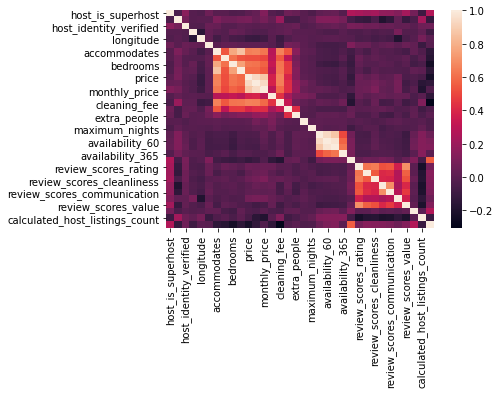

In [9]:
sns.heatmap(df_1drop[df_1drop.columns[0:]].corr(), annot=False, fmt=".1f");

Para una primera aproximación, se van a tener en cuenta las variables que tiene una alta correlación con la variable "price"

In [10]:
to_sel = ['accommodates','bathrooms', 'bedrooms', 'beds','price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people'] 
df_aprox1 = df_1drop.loc[:, to_sel]

Se genera dataset eliminando las filas que tengan al menos un NaN 

In [11]:
df_totrain1 = df_aprox1.dropna(axis = 0, how = 'any')
df_totrain1.describe()

,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people
count,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000
mean,3.848431,1.333629,1.465364,1.971581,145.480166,292.399645,67.898165,2.074600,14.761397
std,2.253381,0.655025,1.026954,1.310872,102.624302,273.171920,48.966308,1.609473,19.127702
min,1.000000,0.000000,0.000000,1.000000,28.000000,95.000000,5.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,85.000000,150.000000,35.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,2.000000,115.000000,250.000000,55.000000,2.000000,10.000000
75%,5.000000,1.500000,2.000000,3.000000,170.000000,350.000000,90.000000,2.000000,25.000000
max,16.000000,4.500000,7.000000,15.000000,999.000000,5000.000000,300.000000,13.000000,300.000000


Se crea el dataframe X de caracteristicas el dataframe Y que es la columna del precio nuestro target 

In [12]:
X = df_totrain1.drop(['price'],axis = 1)
y = df_totrain1['price']

Se divide el dataset en los conjuntos de entrenamiento y test, se crea un scaler a partir delos datos de entrenamiento y se normalizan los datos tanto de entrenamiento como de test.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print("Shape X_train = {}, Shape y_train = {}, Shape X_test = {}, Shape y_test = {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Shape X_train = (1351, 8), Shape y_train = (1351,), Shape X_test = (338, 8), Shape y_test = (338,)


Se crean y entrenan los modelos de regresión lineal, random forest, y SVR. Se comparan con respecto al R2 score

In [22]:
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, criterion = 'mse')
sv_model = SVR(kernel= 'rbf', C= 1000, gamma= 0.01, epsilon=1, cache_size = 500)
models = [lr_model, rf_model, sv_model]
index=['LinearRegression','RandomForestRegressor','SVR']
columns=['Train r2 score','Test r2 score','Test MSE']
columns_plot=['Y test','error_LR','error_RF','error_SV']
df_summary=pd.DataFrame(data=None,index=index,columns=columns)
df_plot=pd.DataFrame(data=None,columns=columns_plot)
df_plot['Y test'] = y_test.values
for n,model in enumerate(models):
    model.fit(X_train, y_train)
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)
    score = []
    score.append(r2_score(y_train, y_train_preds))
    score.append(r2_score(y_test, y_test_preds))
    score.append(mean_squared_error(y_test, y_test_preds))
    df_summary.loc[df_summary.index[n]] = score
    error = (np.abs(y_test-y_test_preds)/y_test)*100
    df_plot.loc[:,df_plot.columns[n+1]] = np.array(error)
df_summary


,Train r2 score,Test r2 score,Test MSE
LinearRegression,0.609324,0.488408,5329.310089
RandomForestRegressor,0.939896,0.458012,5645.949309
SVR,0.65609,0.481661,5399.589944


In [36]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [52]:
fig = make_subplots(rows=3, cols=1)
for ng,col in enumerate(df_plot.columns):
    if col != "Y test":
        fig.add_trace(
            go.Scatter(x=df_plot['Y test'], y=df_plot[col],mode="markers",name = col),
            row=ng, col=1
        )
#fig = px.scatter(df_plot, x='Y test', y="error_LR")
#fig.append_trace(px.scatter(df_plot, x='Y test', y="error_LR"), row=1, col=1)
#fig.update_layout(yaxis_range=[0,200],title_text="Error Aprox 1")
fig.show()

Graficando el error relativo

In [50]:
for ng,col in enumerate(df_plot.columns):
    if col != "Y test":
        print(ng,col)


1 error_LR
2 error_RF
3 error_SV


Ahora, para una segunda aproximación, se genera dataset con todas la variable numéricas preseleccionadas con valores numericos y se eliminan las filas que tengan al menos un NaN 

In [58]:
numeric_cols = df_1drop[df_1drop.columns].describe()
df_aprox2 = df_1drop[numeric_cols.columns]
df_totrain2 = df_aprox2.dropna(axis = 0, how = 'any')
df_totrain2.describe()

,host_is_superhost,host_total_listings_count,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month
count,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,...,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000
mean,0.270423,7.519718,0.864789,47.629065,-122.331309,0.940845,3.621127,1.250704,1.333803,1.843662,...,93.849296,9.561972,9.523944,9.718310,9.733803,9.526761,9.366197,0.207042,5.259155,1.882324
std,0.444491,12.838325,0.342190,0.043787,0.032234,0.236081,2.013734,0.587691,0.896545,1.110056,...,7.803373,0.837059,0.842366,0.724021,0.674635,0.713552,0.857053,0.405472,9.654710,1.613269
min,0.000000,1.000000,0.000000,47.510164,-122.415848,0.000000,1.000000,0.500000,0.000000,1.000000,...,20.000000,2.000000,4.000000,2.000000,2.000000,4.000000,2.000000,0.000000,1.000000,0.020000
25%,0.000000,1.000000,1.000000,47.607906,-122.352248,1.000000,2.000000,1.000000,1.000000,1.000000,...,92.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.000000,1.000000,0.690000
50%,0.000000,2.000000,1.000000,47.625265,-122.328858,1.000000,3.000000,1.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,1.000000,1.370000
75%,1.000000,5.000000,1.000000,47.662278,-122.309819,1.000000,4.000000,1.000000,2.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,3.000000,2.770000
max,1.000000,48.000000,1.000000,47.732647,-122.256081,1.000000,15.000000,4.500000,6.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,37.000000,10.950000


In [59]:
X2 = df_totrain2.drop(['price','weekly_price','monthly_price'],axis = 1)
y2 = df_totrain2['price']

In [60]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = .20, random_state=42)
print("Shape X_train = {}, Shape y_train = {}, Shape X_test = {}, Shape y_test = {}".format(X2_train.shape, y2_train.shape, X2_test.shape, y2_test.shape))
scaler2 = StandardScaler()
scaler2.fit(X2_train)
X2_train = scaler2.transform(X2_train)
X2_test = scaler2.transform(X2_test)

lr2_model = LinearRegression()
rf2_model = RandomForestRegressor(n_estimators=100, criterion = 'mse')
sv2_model = SVR(kernel= 'rbf', C= 1000, gamma= 0.01, epsilon=1, cache_size = 500)
models2 = [lr2_model, rf2_model, sv2_model]
index=['LinearRegression','RandomForestRegressor','SVR']
columns=['Train r2 score','Test r2 score','Test MSE']
df2_summary=pd.DataFrame(data=None,index=index,columns=columns)
for n,model in enumerate(models2):
    model.fit(X2_train, y2_train)
    y2_train_preds = model.predict(X2_train)
    y2_test_preds = model.predict(X2_test)
    score = []
    score.append(r2_score(y2_train, y2_train_preds))
    score.append(r2_score(y2_test, y2_test_preds))
    score.append(mean_squared_error(y2_test, y2_test_preds))
    df2_summary.loc[df2_summary.index[n]] = score
df2_summary



Shape X_train = (568, 31), Shape y_train = (568,), Shape X_test = (142, 31), Shape y_test = (142,)


,Train r2 score,Test r2 score,Test MSE
LinearRegression,0.640288,0.539263,3902.846345
RandomForestRegressor,0.944792,0.52275,4042.729137
SVR,0.883981,0.485325,4359.744655


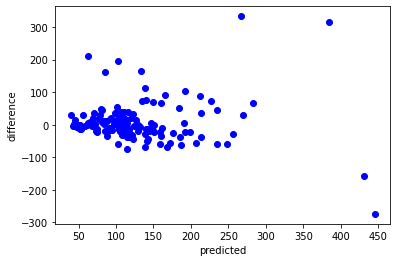

In [61]:
preds_vs_act = pd.DataFrame(np.hstack([y2_test.values.reshape(y2_test.size,1), y2_test_preds.reshape(y2_test.size,1)]))
preds_vs_act.columns = ['actual', 'preds']
preds_vs_act['diff'] = preds_vs_act['actual'] - preds_vs_act['preds']

plt.plot(preds_vs_act['preds'], preds_vs_act['diff'], 'bo');
plt.xlabel('predicted');
plt.ylabel('difference');

Tercera aproximación: se genera dataset con todas la variable numéricas preseleccionadas con valores numericos y se rellenan los valores NaN por la media de su respectiva variable

In [62]:
numeric_cols = df_1drop[df_1drop.columns].describe()
df_aprox3 = df_1drop[numeric_cols.columns]


,host_is_superhost,host_total_listings_count,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month
count,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,...,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000
mean,0.203878,7.157757,0.785377,47.628961,-122.333103,0.893662,3.349398,1.259469,1.307712,1.735394,...,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,0.154793,2.946307,2.078919
std,0.402827,28.620648,0.410507,0.043052,0.031745,0.308311,1.977599,0.589130,0.882700,1.139330,...,6.020223,0.635022,0.725880,0.541745,0.517493,0.572542,0.682751,0.361755,5.893029,1.665964
min,0.000000,1.000000,0.000000,47.505088,-122.417219,0.000000,1.000000,0.000000,0.000000,1.000000,...,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,0.000000,1.000000,0.020000
25%,0.000000,1.000000,1.000000,47.609418,-122.354320,1.000000,2.000000,1.000000,1.000000,1.000000,...,94.000000,9.636392,9.000000,9.786709,9.809599,9.000000,9.000000,0.000000,1.000000,0.830000
50%,0.000000,1.000000,1.000000,47.623601,-122.328874,1.000000,3.000000,1.000000,1.000000,1.000000,...,95.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.452245,0.000000,1.000000,2.000000
75%,0.000000,3.000000,1.000000,47.662694,-122.310800,1.000000,4.000000,1.000000,2.000000,2.000000,...,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,2.000000,2.660000
max,1.000000,502.000000,1.000000,47.733358,-122.240607,1.000000,16.000000,8.000000,7.000000,15.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,37.000000,12.150000


In [63]:
X3 = df_totrain3.drop(['price','weekly_price','monthly_price'],axis = 1)
y3 = df_totrain3['price']
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = .20, random_state=42)
scaler3 = StandardScaler()
scaler3.fit(X3_train)
X3_train = scaler3.transform(X3_train)
X3_test = scaler3.transform(X3_test)

lr3_model = LinearRegression()
rf3_model = RandomForestRegressor(n_estimators=100, criterion = 'mse')
sv3_model = SVR(kernel= 'rbf', C= 1000, gamma= 0.01, epsilon=1, cache_size = 500)
models3 = [lr3_model, rf3_model, sv3_model]
index=['LinearRegression','RandomForestRegressor','SVR']
columns=['Train r2 score','Test r2 score','Test MSE']
df3_summary=pd.DataFrame(data=None,index=index,columns=columns)
for n,model in enumerate(models3):
    model.fit(X3_train, y3_train)
    y3_train_preds = model.predict(X3_train)
    y3_test_preds = model.predict(X3_test)
    score = []
    score.append(r2_score(y3_train, y3_train_preds))
    score.append(r2_score(y3_test, y3_test_preds))
    score.append(mean_squared_error(y3_test, y3_test_preds))
    df3_summary.loc[df3_summary.index[n]] = score
df3_summary

,Train r2 score,Test r2 score,Test MSE
LinearRegression,0.538072,0.574392,3454.360483
RandomForestRegressor,0.936798,0.639259,2927.884616
SVR,0.705888,0.653731,2810.422753


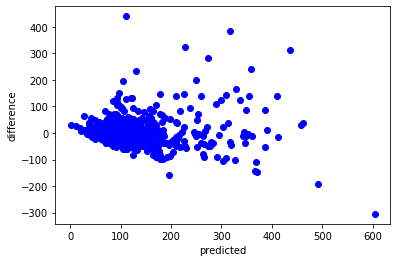

In [33]:
preds_vs_act = pd.DataFrame(np.hstack([y3_test.values.reshape(y3_test.size,1), y3_test_preds.reshape(y3_test.size,1)]))
preds_vs_act.columns = ['actual', 'preds']
preds_vs_act['diff'] = preds_vs_act['actual'] - preds_vs_act['preds']

plt.plot(preds_vs_act['preds'], preds_vs_act['diff'], 'bo');
plt.xlabel('predicted');
plt.ylabel('difference');

In [23]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [33]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)


In [28]:
parameters = {'kernel':('linear', 'rbf','Polynomial'), 'C':[0.1,1, 10, 100,1000,10000],                        'gamma':[0.01,0.1,1, 10, 100], 'degree':[2,3,4],
             'epsilon' : [0.001, 0.01, 0.1,1, 10, 100], 'cache_size' : [500]}
model = SVR()
clf = GridSearchCV(estimator=model, param_grid=parameters, n_jobs=4, verbose = 2)

In [29]:
clf.fit(X3_train, y3_train)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


GridSearchCV(estimator=SVR(), n_jobs=4,
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000],
                         'cache_size': [500], 'degree': [2, 3, 4],
                         'epsilon': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.01, 0.1, 1, 10, 100],
                         'kernel': ('linear', 'rbf', 'Polynomial')},
             verbose=2)

In [30]:
pd.DataFrame(clf.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_cache_size,param_degree,param_epsilon,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.267085,0.015025,0.035705,0.004155,0.1,500,2,0.001,0.01,linear,"{'C': 0.1, 'cache_size': 500, 'degree': 2, 'ep...",0.472242,0.426879,0.461401,0.559631,0.547520,0.493535,0.051404,466
1,0.344677,0.018135,0.200862,0.013300,0.1,500,2,0.001,0.01,rbf,"{'C': 0.1, 'cache_size': 500, 'degree': 2, 'ep...",-0.041808,-0.006405,0.000539,0.005413,-0.043564,-0.017165,0.021181,850
2,0.001397,0.000490,0.000000,0.000000,0.1,500,2,0.001,0.01,Polynomial,"{'C': 0.1, 'cache_size': 500, 'degree': 2, 'ep...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1343
3,0.267084,0.009300,0.034110,0.001323,0.1,500,2,0.001,0.1,linear,"{'C': 0.1, 'cache_size': 500, 'degree': 2, 'ep...",0.472242,0.426879,0.461401,0.559631,0.547520,0.493535,0.051404,466
4,0.342085,0.015931,0.209439,0.015020,0.1,500,2,0.001,0.1,rbf,"{'C': 0.1, 'cache_size': 500, 'degree': 2, 'ep...",-0.104754,-0.060184,-0.049390,-0.054593,-0.113124,-0.076409,0.026909,979


In [31]:
clf.best_params_

{'C': 1000,
 'cache_size': 500,
 'degree': 2,
 'epsilon': 1,
 'gamma': 0.01,
 'kernel': 'rbf'}

{'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.1, 'kernel': 'linear'}

In [71]:
cat_vars_int = df_1drop.select_dtypes(include=['object']).copy().columns
cat_vars_int

Index(['host_since', 'host_response_rate', 'host_acceptance_rate',
       'property_type', 'room_type', 'bed_type', 'amenities',
       'calendar_updated', 'first_review', 'last_review',
       'cancellation_policy'],
      dtype='object')

In [99]:
df_cat = df_1drop.copy()
for var in  cat_vars_int:
    # for each cat add dummy var, drop original column
    df_cat = pd.concat([df_cat.drop(var, axis=1), pd.get_dummies(df_cat[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

df_cat.describe()

,host_is_superhost,host_total_listings_count,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,...,last_review_2015-12-27,last_review_2015-12-28,last_review_2015-12-29,last_review_2015-12-30,last_review_2015-12-31,last_review_2016-01-01,last_review_2016-01-02,last_review_2016-01-03,cancellation_policy_moderate,cancellation_policy_strict
count,3816.000000,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,...,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000
mean,0.203878,7.157757,0.785377,47.628961,-122.333103,0.893662,3.349398,1.259469,1.307712,1.735394,...,0.013358,0.015977,0.019644,0.020168,0.015191,0.022787,0.024620,0.009429,0.327658,0.371137
std,0.402932,28.628149,0.410614,0.043052,0.031745,0.308311,1.977599,0.590369,0.883395,1.139480,...,0.114816,0.125403,0.138791,0.140592,0.122329,0.149243,0.154985,0.096657,0.469421,0.483172
min,0.000000,1.000000,0.000000,47.505088,-122.417219,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,47.609418,-122.354320,1.000000,2.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,47.623601,-122.328874,1.000000,3.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,1.000000,47.662694,-122.310800,1.000000,4.000000,1.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,502.000000,1.000000,47.733358,-122.240607,1.000000,16.000000,8.000000,7.000000,15.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [101]:
df_totrain4 = df_cat.apply(lambda x: x.fillna(x.mean()),axis=0)
df_totrain4.describe()

,host_is_superhost,host_total_listings_count,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,...,last_review_2015-12-27,last_review_2015-12-28,last_review_2015-12-29,last_review_2015-12-30,last_review_2015-12-31,last_review_2016-01-01,last_review_2016-01-02,last_review_2016-01-03,cancellation_policy_moderate,cancellation_policy_strict
count,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,...,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000
mean,0.203878,7.157757,0.785377,47.628961,-122.333103,0.893662,3.349398,1.259469,1.307712,1.735394,...,0.013358,0.015977,0.019644,0.020168,0.015191,0.022787,0.024620,0.009429,0.327658,0.371137
std,0.402827,28.620648,0.410507,0.043052,0.031745,0.308311,1.977599,0.589130,0.882700,1.139330,...,0.114816,0.125403,0.138791,0.140592,0.122329,0.149243,0.154985,0.096657,0.469421,0.483172
min,0.000000,1.000000,0.000000,47.505088,-122.417219,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,47.609418,-122.354320,1.000000,2.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,47.623601,-122.328874,1.000000,3.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,1.000000,47.662694,-122.310800,1.000000,4.000000,1.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,502.000000,1.000000,47.733358,-122.240607,1.000000,16.000000,8.000000,7.000000,15.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [103]:
X4 = df_totrain4.drop(['price','weekly_price','monthly_price'],axis = 1)
y4 = df_totrain4['price']
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size = .20, random_state=42)
scaler4 = StandardScaler()
scaler4.fit(X4_train)
X4_train = scaler4.transform(X4_train)
X4_test = scaler4.transform(X4_test)

lr4_model = LinearRegression()
rf4_model = RandomForestRegressor(n_estimators=100, criterion = 'mse')
sv4_model = SVR(kernel= 'rbf', C= 1000, gamma= 0.01, epsilon=1, cache_size = 500)
models4 = [lr4_model, rf4_model, sv4_model]
index=['LinearRegression','RandomForestRegressor','SVR']
columns=['Train r2 score','Test r2 score','Test MSE']
df4_summary=pd.DataFrame(data=None,index=index,columns=columns)
for n,model in enumerate(models4):
    model.fit(X4_train, y4_train)
    y4_train_preds = model.predict(X4_train)
    y4_test_preds = model.predict(X4_test)
    score = []
    score.append(r2_score(y4_train, y4_train_preds))
    score.append(r2_score(y4_test, y4_test_preds))
    score.append(mean_squared_error(y4_test, y4_test_preds))
    df3_summary.loc[df3_summary.index[n]] = score
df3_summary

,Train r2 score,Test r2 score,Test MSE
LinearRegression,0.999988,-162582965210863665152.0,1319572920286364945088512.0
RandomForestRegressor,0.944719,0.683832,2566.114917
SVR,0.999868,0.000773,8110.034681
